In [17]:
import numpy as np
from maxvolpy.maxvol import maxvol
from numpy.polynomial import Chebyshev as T
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lu as lu
from gen_mat import *
from block_rect_maxvol import *
import scipy.linalg
%matplotlib inline

In [18]:
nder = 2 # 
expansion = 5
n = 600 # number of points
n_test = 5000 #points on test grid
p_size = (nder+1)*expansion #number of monoms (number of columns)
interval = [-1, 1]  # interval of x_test
x = 2*np.random.rand(n, nder)-1

In [19]:
c = GenMat(p_size, x,poly=cheb, poly_diff=cheb_diff, debug=False,pow_p=1)
# c = GenMat(p_size, x, poly=trigpoly, poly_diff=trigpoly_diff, debug=False, pow_p=1)
print c.shape
# turn matrix to the block structure
A = matrix_prep(c,nder+1,n)
print A.shape

(1800, 15)
(1800, 15)


### Testing the new most general environment

78
125
125
441


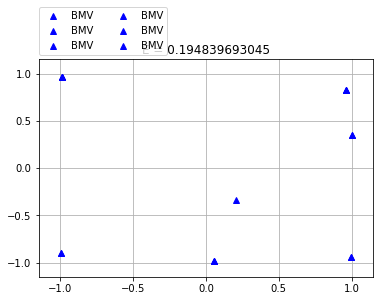

In [20]:
### generating test points
points_test = test_points_gen(n_test,nder,distrib='random') 
### evaluating test
f = open("func=gauss.txt","w+")
for expansion in range(1,4):
    for N_rows in range((expansion*(nder+1)), 2*(nder+1)*expansion, nder+1):
        error = test(A,x,points_test,nder,expansion,N_rows,gauss)
        f.write("error={}_Nrows={}_expans={} \n".format(error, N_rows, expansion))
f.close()

In [21]:
def file_extraction(Filepath):
    f = open(Filepath)
    line = f.readline()
    error, N_rows, N_col =[],[],[]
     
    while line != "":
        pos1 = line.find('error=') + len('error=')
        pos2 = line.find('_Nrows=')
        pos3 = line.find('_expans=')
        pos4 = line.find('\n')
        error.append(float(line[pos1:pos2]))
        N_rows.append(int(line[pos2+len('_Nrows='):pos3]))
        N_col.append(int(line[pos3+len('_expans=') :pos4]))
        line = f.readline()
    f.close()
    return (error, N_rows, N_col)

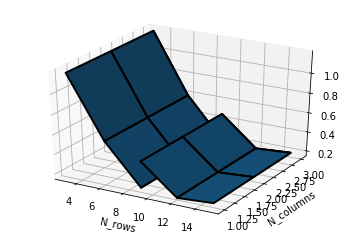

In [24]:
error, N_row,N_col = file_extraction("func=gauss.txt")
fig = plt.figure()
ax = fig.gca(projection='3d')
N_row, N_col = np.meshgrid(N_row, N_col)
ax.plot_surface(N_row, N_col, error, edgecolor='black', linewidth=2)
ax.legend()
ax.set_xlabel('N_rows', fontsize=10)
ax.set_ylabel('N_columns')
plt.show()

### Old computation versions

#### Information about initial matrix

In [ ]:
print la.det(A[:A.shape[1]])
print la.matrix_rank(A)
print la.matrix_rank(A[:A.shape[1]])
_,s,_ = scipy.linalg.svd(A)
print s

piv,_ = maxvol(A)
print piv
print la.det(A[piv])

In [ ]:
### returns 2 values - function on domain, and block structured
def rhs(points, nder, mode = 'gauss'):
    if mode == 'gauss':
        block_rhs = np.zeros((nder+1)*(points.shape[0]))
        func = 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))# + (points[:,2]**2)/2.)) # Gaussian
        for i in range(points.shape[0]):
            block_rhs[i*(nder+1)] = func[i]
            for j in range(nder):
                block_rhs[i*(nder+1)+j+1] = -1*(points[i,j])*func[i]
    if mode == '3D' :
        block_rhs = np.zeros((nder+1)*(points.shape[0]))
        func = 2*((points[:,0]**2)/2. + (points[:,1]**2)/2. + (points[:,2]**2)/2.) # Gaussian
        for i in range(points.shape[0]):
            block_rhs[i*(nder+1)] = func[i]
            for j in range(nder):
                block_rhs[i*(nder+1)+j+1] = 2 * points[i,j]
    return func, block_rhs     

#### Rectangular block maxvol

In [ ]:
k = 15 ### number of rows for LSM
assert k//(nder+1)!=0
assert (k>=A.shape[1])
a,b,final_piv,d,e = rect_block_maxvol(A, nder, Kmax = k, max_iters=100, rect_tol = 0.05, tol = 0.0, debug = False, ext_debug = True)

In [ ]:
### solve LSM
f,t = rhs(x,nder, mode = 'gauss')
A_test = GenMat(p_size, points_test,poly=cheb, debug=False,pow_p=1, ToGenDiff=False)

In [ ]:
f_test,_ = rhs(points_test,nder)

In [ ]:
### Take number of rows that we really need
c = final_piv[:k]

In [ ]:
c_block, res_x, rank, s = np.linalg.lstsq(A[c],t[c])

In [ ]:
taken_p = x[c[::(nder+1)]/(nder+1),:]

In [ ]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
l_bound = interval[0]
u_bound = interval[1]
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
#plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(taken_p[:,0],taken_p[:,1], 'b^', label = "BMV")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [ ]:
print("GD error = ", la.norm(f_test - np.dot(A_test, c_block), np.inf) / la.norm(f_test, np.inf), "\n")